# Multi-task GRU Model

This notebook trains a regression+classification GRU model using data from multiple stocks.

In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

from numerical_preprocessing import *

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

tf.random.set_seed(1234)

Check if GPU is available

In [3]:
print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow Version: 2.16.2
Num GPUs Available: 1


In [4]:
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

### Import Dataset

In [5]:
data = pd.read_csv("../stock_yfinance_data.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


### Preprocess Stocks

In [6]:
feature_cols = ['percent_open', 'percent_high', 'percent_low', 'percent_close', 'volume', 
                'sma', 'ema', 'rsi', 'macd', 'bb_middle', 'bb_upper', 'bb_lower']
target_cols = ['future_magnitude', 'future_direction']
num_features = len(feature_cols)
num_targets = len(target_cols)
prev_days = 20
future_days = 1
test_size = 30 # days per stock

In [7]:
train_x = []
train_y = []
test_x = []
test_y = []

train_tickers = []
test_tickers = []
scalers = {}

train_data = pd.DataFrame({})
test_data = pd.DataFrame({})

tickers = data['Stock Name'].unique()

for ticker in tickers:

    # Filter for stock data
    stock_data = data[data['Stock Name'] == ticker]

    # Clean data
    stock_data = clean_stock_data(stock_data, ticker=None)

    # Calculate percent change between trading days
    stock_data['percent_open'], stock_data['percent_high'], stock_data['percent_low'], stock_data['percent_close'] = percent_price_change(stock_data)
    
    # Calculate technical indicators
    stock_data['sma'] = simple_moving_average(stock_data)
    stock_data['ema'] = exponential_moving_average(stock_data)
    stock_data['rsi'] = calculate_rsi(stock_data)
    stock_data['macd_line'], stock_data['macd_signal'], stock_data['macd'] = calculate_macd(stock_data)
    stock_data['bb_middle'], stock_data['bb_upper'], stock_data['bb_lower'] = bollinger_bands(stock_data)
    stock_data['future_percent'] = calculate_future_close(stock_data)
    stock_data.dropna(inplace=True)

    # Compute regression & binary classification targets before scaling
    stock_data['future_magnitude'] = stock_data['future_percent'].abs() # convert to magnitude
    stock_data['future_direction'] = (stock_data['future_percent'] > 0).astype(int)  # 1 if up, 0 if down

    # Normalize features
    scaler = MinMaxScaler()
    scale_cols = feature_cols+[target_cols[0]]
    stock_data.loc[:, scale_cols] = scaler.fit_transform(stock_data.loc[:, scale_cols])
    scalers[ticker] = scaler

    # Generate training & test feature data
    feature_array = stock_data[feature_cols].to_numpy()
    stock_x = generate_feature_data(feature_array, sequence_size=prev_days, pred_size=future_days)

    # Slice stock_data properly to match sequence data
    stock_data = stock_data.iloc[prev_days:-future_days].reset_index(drop=True)

    # Stack y1-magnitude (regression) and y2-direction (classification)
    stock_y1 = stock_data['future_magnitude'].to_numpy()
    stock_y2 = stock_data['future_direction'].to_numpy()
    train_y.append(np.column_stack((stock_y1[:-test_size], stock_y2[:-test_size])))
    test_y.append(np.column_stack((stock_y1[-test_size:], stock_y2[-test_size:])))

    # Append data
    train_x.append(stock_x[:-test_size])
    test_x.append(stock_x[-test_size:])

    # Track stock names for each entry
    train_tickers.extend([ticker] * (len(stock_x) - test_size))
    test_tickers.extend([ticker] * test_size)

    # Append clean stock data
    train_data = pd.concat([train_data, stock_data.iloc[:-test_size]], ignore_index=True)
    test_data = pd.concat([test_data, stock_data.iloc[-test_size:]], ignore_index=True)

# Convert training and testing sets to arrays
train_x = np.vstack(train_x)
train_y = np.vstack(train_y)
test_x = np.vstack(test_x)
test_y = np.vstack(test_y)

# Convert stock labels to arrays
train_tickers = np.array(train_tickers)
test_tickers = np.array(test_tickers)

In [8]:
train_x.shape

(4525, 20, 12)

In [9]:
train_y.shape

(4525, 2)

In [10]:
train_tickers.shape

(4525,)

In [11]:
scalers

{'TSLA': MinMaxScaler(),
 'MSFT': MinMaxScaler(),
 'PG': MinMaxScaler(),
 'META': MinMaxScaler(),
 'AMZN': MinMaxScaler(),
 'GOOG': MinMaxScaler(),
 'AMD': MinMaxScaler(),
 'AAPL': MinMaxScaler(),
 'NFLX': MinMaxScaler(),
 'TSM': MinMaxScaler(),
 'KO': MinMaxScaler(),
 'F': MinMaxScaler(),
 'COST': MinMaxScaler(),
 'DIS': MinMaxScaler(),
 'VZ': MinMaxScaler(),
 'CRM': MinMaxScaler(),
 'INTC': MinMaxScaler(),
 'BA': MinMaxScaler(),
 'BX': MinMaxScaler(),
 'NOC': MinMaxScaler(),
 'PYPL': MinMaxScaler(),
 'ENPH': MinMaxScaler(),
 'NIO': MinMaxScaler(),
 'ZS': MinMaxScaler(),
 'XPEV': MinMaxScaler()}

In [12]:
train_data

,date,open,high,low,close,adj_close,volume,stock_name,percent_open,percent_high,...,rsi,macd_line,macd_signal,macd,bb_middle,bb_upper,bb_lower,future_percent,future_magnitude,future_direction
0,2021-11-24,360.130005,377.589996,354.000000,372.000000,372.000000,0.229401,TSLA,0.313920,0.350731,...,0.284683,14.595007,17.303938,0.262689,0.996722,0.878327,0.975157,-3.053760,0.223228,0
1,2021-11-26,366.489990,369.593323,360.333344,360.640015,360.640015,0.000000,TSLA,0.374061,0.193530,...,0.261214,13.006359,16.444422,0.223167,0.997296,0.878240,0.976467,5.090023,0.374185,1
2,2021-11-29,366.996674,380.890015,366.730011,378.996674,378.996674,0.164125,TSLA,0.551208,0.546666,...,0.392891,13.077820,15.771102,0.263538,1.000000,0.880661,0.978689,0.683382,0.047502,1
3,2021-11-30,381.456665,389.333344,372.666656,381.586670,381.586670,0.324958,TSLA,0.490397,0.383821,...,0.611356,13.191382,15.255158,0.297660,0.992493,0.864661,0.985450,-4.346763,0.319084,0
4,2021-12-01,386.899994,390.946655,363.586670,365.000000,365.000000,0.234811,TSLA,0.530992,0.368343,...,0.464531,11.806873,14.565501,0.259995,0.983438,0.853706,0.981974,-0.949774,0.067250,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4520,2022-08-09,23.320000,23.709999,22.139999,22.690001,22.690001,0.157525,XPEV,0.408956,0.242441,...,0.215070,-1.467863,-1.212932,0.503113,0.301022,0.320883,0.257261,0.925514,0.029893,1
4521,2022-08-10,23.110001,23.110001,22.040001,22.900000,22.900000,0.147302,XPEV,0.430488,0.216461,...,0.223351,-1.464131,-1.263172,0.524201,0.290742,0.303252,0.256415,7.467253,0.251575,1
4522,2022-08-11,23.580000,25.910000,23.209999,24.610001,24.610001,0.404596,XPEV,0.463771,0.519657,...,0.558296,-1.308111,-1.272160,0.588671,0.282737,0.279388,0.267816,-0.812681,0.026069,0
4523,2022-08-12,23.670000,24.480000,23.379999,24.410000,24.410000,0.096472,XPEV,0.261734,0.152582,...,0.578805,-1.186920,-1.255112,0.629360,0.275060,0.253749,0.282027,-3.727980,0.124861,0


### Plot Stock Price

In [13]:
ticker = 'TSLA'
plotting_data = train_data[train_data['stock_name'] == ticker]
plotting_data.reset_index(inplace=True)

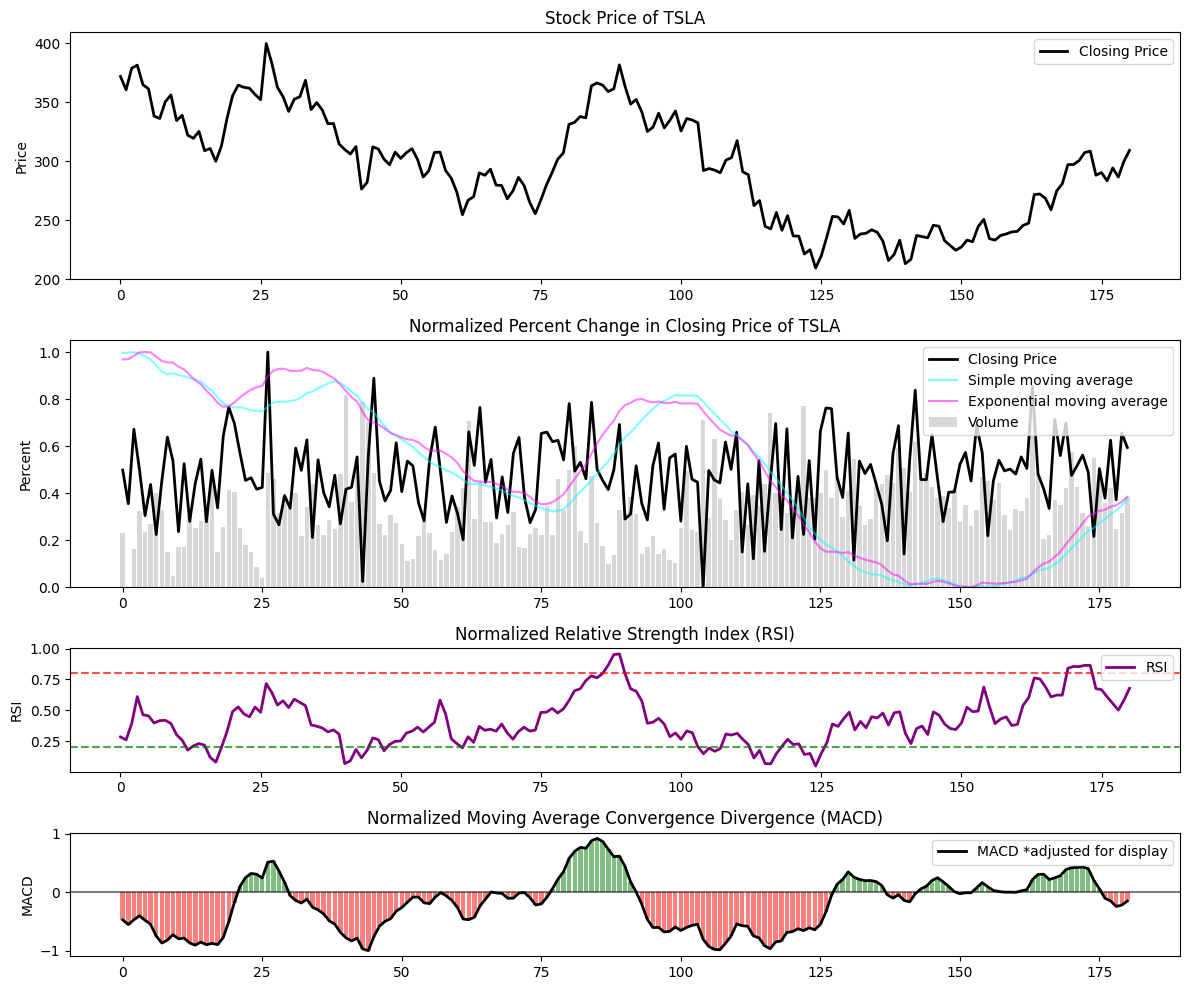

In [14]:
fig, axs = plt.subplots(4, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 2, 1, 1]})

# Plot stock price
axs[0].plot(plotting_data.index, plotting_data['close'], label="Closing Price", color='black', linewidth=2)
axs[0].set_title(f"Stock Price of {ticker}")
axs[0].set_ylabel("Price")
axs[0].legend(loc="upper right")

# Plot percent change with volume
axs[1].bar(plotting_data.index, plotting_data['volume'], label=f"Volume", color='grey', alpha=0.3)
axs[1].plot(plotting_data.index, plotting_data['percent_close'], label="Closing Price", color='black', linewidth=2)
axs[1].plot(plotting_data.index, plotting_data['sma'], label="Simple moving average", color='cyan', alpha=0.5)
axs[1].plot(plotting_data.index, plotting_data['ema'], label="Exponential moving average", color='magenta', alpha=0.5)
axs[1].set_title(f"Normalized Percent Change in Closing Price of {ticker}")
axs[1].set_ylabel("Percent")
axs[1].legend(loc="upper right")

# Plot RSI
axs[2].plot(plotting_data.index, plotting_data['rsi'], label="RSI", color='purple', linewidth=2)
axs[2].axhline(0.8, linestyle='dashed', color='red', alpha=0.7)
axs[2].axhline(0.2, linestyle='dashed', color='green', alpha=0.7)
axs[2].set_title("Normalized Relative Strength Index (RSI)")
axs[2].set_ylabel("RSI")
axs[2].legend(loc="upper right")

# Plot MACD
axs[3].plot(plotting_data.index, 2*(plotting_data['macd']-0.5), label="MACD *adjusted for display", color='black', linewidth=2)
axs[3].bar(plotting_data.index, 2*(plotting_data['macd']-0.5), 
           color=['green' if v >= 0 else 'red' for v in 2*(plotting_data['macd']-0.5)], 
           alpha=0.5)
axs[3].axhline(0, color='black', alpha=0.5)
axs[3].set_title("Normalized Moving Average Convergence Divergence (MACD)")
axs[3].set_ylabel("MACD")
axs[3].legend(loc="upper right")

plt.tight_layout()
plt.show()

### Define Model

In [15]:
class GRU_Model(tf.keras.Model):
    def __init__(self, num_layers, hidden_dim, dropout_rate=0.1):
        super(GRU_Model, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.gru_layers = [
            tf.keras.layers.GRU(
                hidden_dim,
                activation='tanh',
                return_sequences=True
            ) for _ in range(num_layers - 1)
        ]
        
        self.last_gru = tf.keras.layers.GRU(
            hidden_dim,
            activation='tanh',
            return_sequences=False
        )

        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense1 = tf.keras.layers.Dense(hidden_dim // 2, activation="relu")

        self.price_change_output = tf.keras.layers.Dense(1, activation="linear", name="price_change_output")  # Regression
        self.direction_output = tf.keras.layers.Dense(1, activation="sigmoid", name="direction_output")  # Classification

    def call(self, x):
        for gru_layer in self.gru_layers:
            x = gru_layer(x)
            x = self.dropout(x)
        
        x = self.last_gru(x)
        x = self.dropout(x)

        x = self.dense1(x)
        x = self.dropout(x)

        return {
            "price_change_output": self.price_change_output(x),  # Regression Output
            "direction_output": self.direction_output(x)  # Classification Output
        }

### Train Model

In [ ]:
num_layers = 4
hidden_dim = 128
dropout_rate = 0.1

model = GRU_Model(num_layers, hidden_dim, dropout_rate)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss={
        "price_change_output": tf.keras.losses.MeanSquaredError(),
        "direction_output": tf.keras.losses.BinaryCrossentropy()
    },
    loss_weights={
        "price_change_output": 0.2, 
        "direction_output": 0.8
    },
    metrics={
        "price_change_output": ["mae"],
        "direction_output": ["accuracy"]
    }
)

history = model.fit(
    x=train_x,
    y={
        "price_change_output": train_y[:, 0],
        "direction_output": train_y[:, 1]
    },
    epochs=50,
    batch_size=64,
    validation_data=(
        test_x,
        {
            "price_change_output": test_y[:, 0], 
            "direction_output": test_y[:, 1]
        }
    )
)

2025-02-27 23:40:53.682659: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-02-27 23:40:53.682705: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-02-27 23:40:53.682713: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-02-27 23:40:53.682735: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-27 23:40:53.682752: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2025-02-27 23:40:56.936585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


71/71 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - direction_output_accuracy: 0.5316 - direction_output_loss: 0.6911 - loss: 0.5607 - price_change_output_loss: 0.0390 - price_change_output_mae: 0.1465 - val_direction_output_accuracy: 0.4240 - val_direction_output_loss: 0.7007 - val_loss: 0.5648 - val_price_change_output_loss: 0.0219 - val_price_change_output_mae: 0.1040
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - direction_output_accuracy: 0.5424 - direction_output_loss: 0.6874 - loss: 0.5564 - price_change_output_loss: 0.0323 - price_change_output_mae: 0.1339 - val_direction_output_accuracy: 0.4333 - val_direction_output_loss: 0.7045 - val_loss: 0.5676 - val_price_change_output_loss: 0.0212 - val_price_change_output_mae: 0.1041
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - direction_output_accuracy: 0.5487 - direction_output_loss: 0.6868 - loss: 0.5557 - price_change_output_loss: 0.0311 - price_change_output_mae: 0.1308 - val_direction_output_accuracy: 0.4493 - val_directio

### Plot Performance

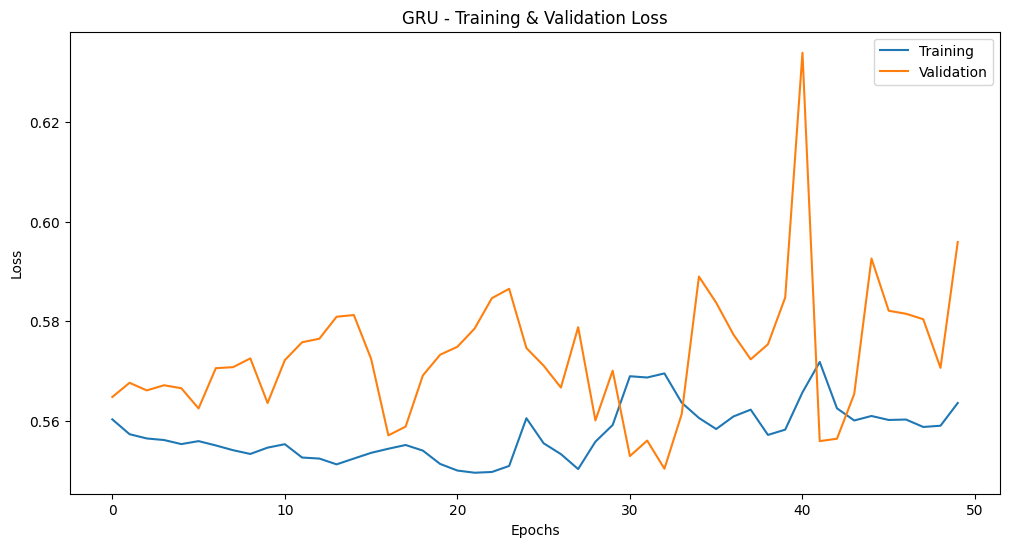

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))

plt.figure(figsize=(12, 6))
plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GRU - Training & Validation Loss')
plt.legend(loc='upper right')
plt.show()

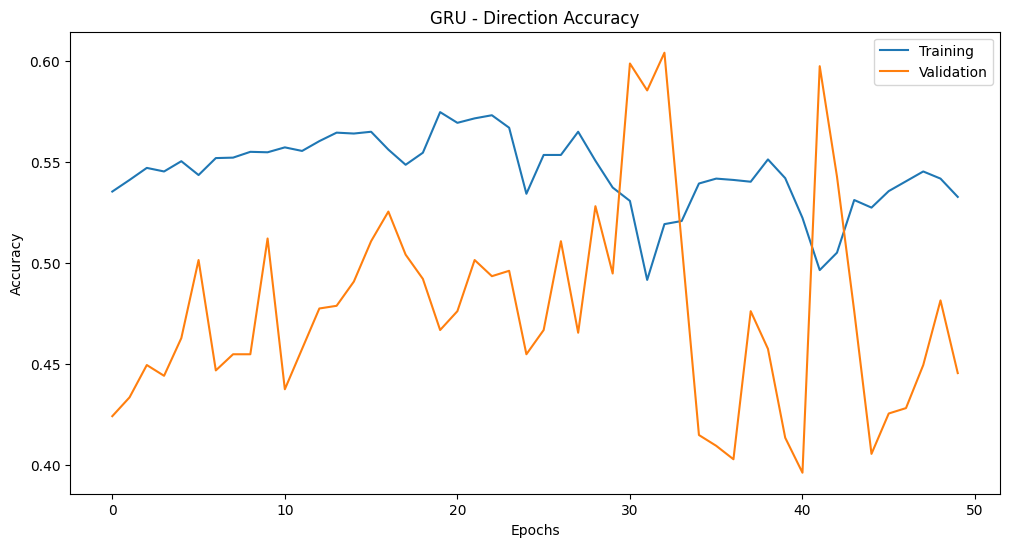

In [18]:
direction_accuracy = history.history['direction_output_accuracy']
val_direction_accuracy = history.history['val_direction_output_accuracy']

plt.figure(figsize=(12, 6))
plt.plot(direction_accuracy, label="Training")
plt.plot(val_direction_accuracy, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("GRU - Direction Accuracy")
plt.legend(loc='upper right')
plt.show()

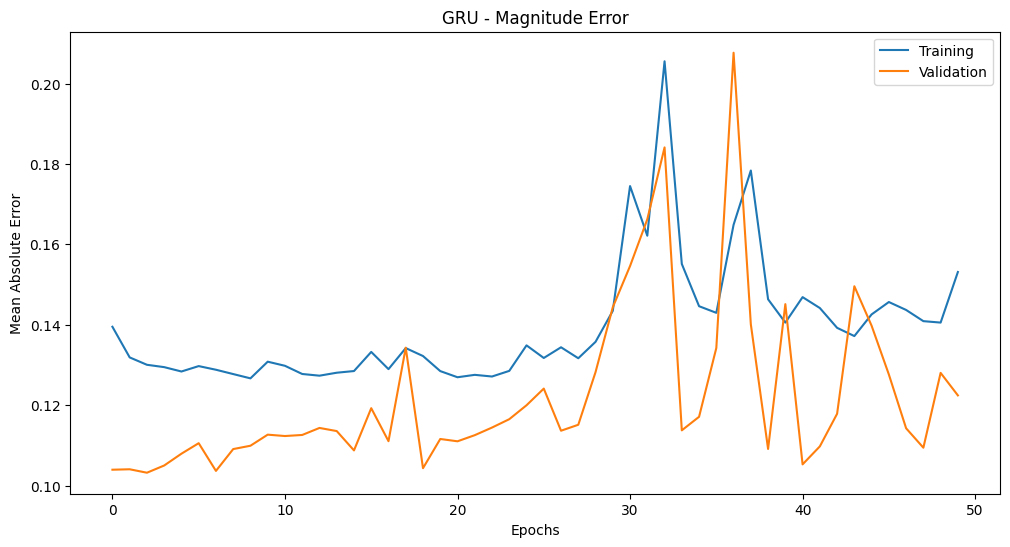

In [19]:
price_change_output_mae = history.history['price_change_output_mae']
val_price_change_output_mae = history.history['val_price_change_output_mae']

plt.figure(figsize=(12, 6))
plt.plot(price_change_output_mae, label="Training")
plt.plot(val_price_change_output_mae, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.title("GRU - Magnitude Error")
plt.legend(loc='upper right')
plt.show()

In [20]:
train_pred = model.predict(train_x)
train_pred_magnitude= train_pred['price_change_output']
train_pred_direction = (train_pred['direction_output'] > 0.5).astype(int)
train_actual_magnitude = train_y[:, 0]
train_actual_direction = train_y[:, 1]

test_pred = model.predict(test_x)
test_pred_magnitude = test_pred['price_change_output']
test_pred_direction = (test_pred['direction_output'] > 0.5).astype(int)
test_actual_magnitude = test_y[:, 0]
test_actual_direction = test_y[:, 1]

142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


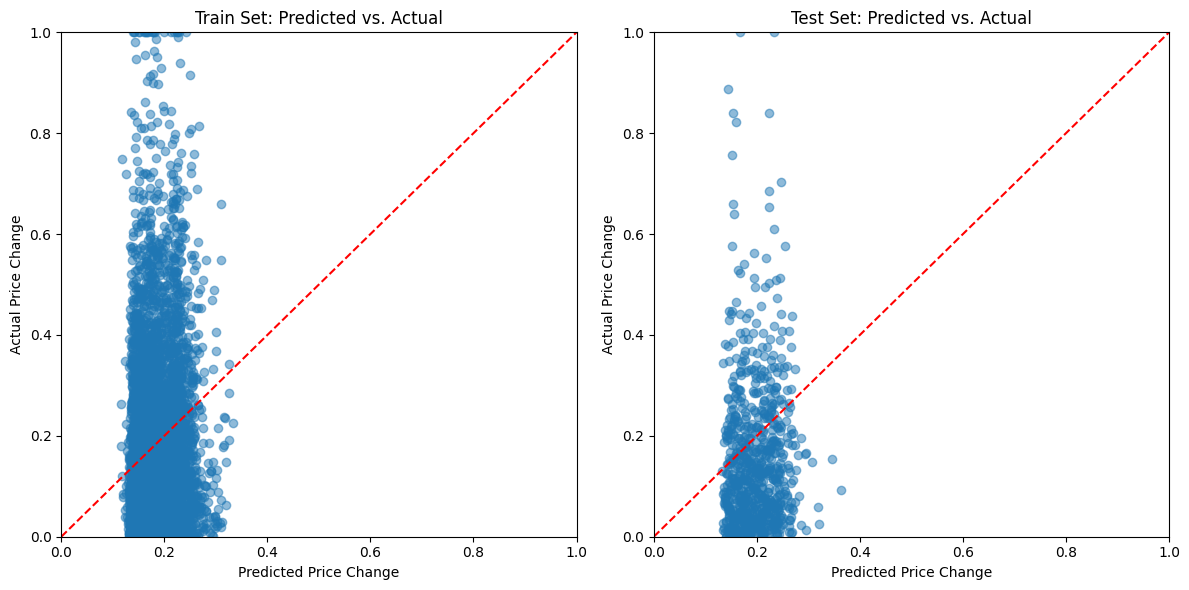

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(train_pred_magnitude, train_actual_magnitude, alpha=0.5, label="Train Data")
axs[0].set_xlabel("Predicted Price Change")
axs[0].set_ylabel("Actual Price Change")
axs[0].set_title("Train Set: Predicted vs. Actual")
axs[0].axline((0, 0), slope=1, color="red", linestyle="dashed")  # Reference line
axs[0].set_xlim([0,1])
axs[0].set_ylim([0,1])

axs[1].scatter(test_pred_magnitude, test_actual_magnitude, alpha=0.5, label="Test Data")
axs[1].set_xlabel("Predicted Price Change")
axs[1].set_ylabel("Actual Price Change")
axs[1].set_title("Test Set: Predicted vs. Actual")
axs[1].axline((0, 0), slope=1, color="red", linestyle="dashed")  # Reference line
axs[1].set_xlim([0,1])
axs[1].set_ylim([0,1])

plt.tight_layout()
plt.show()

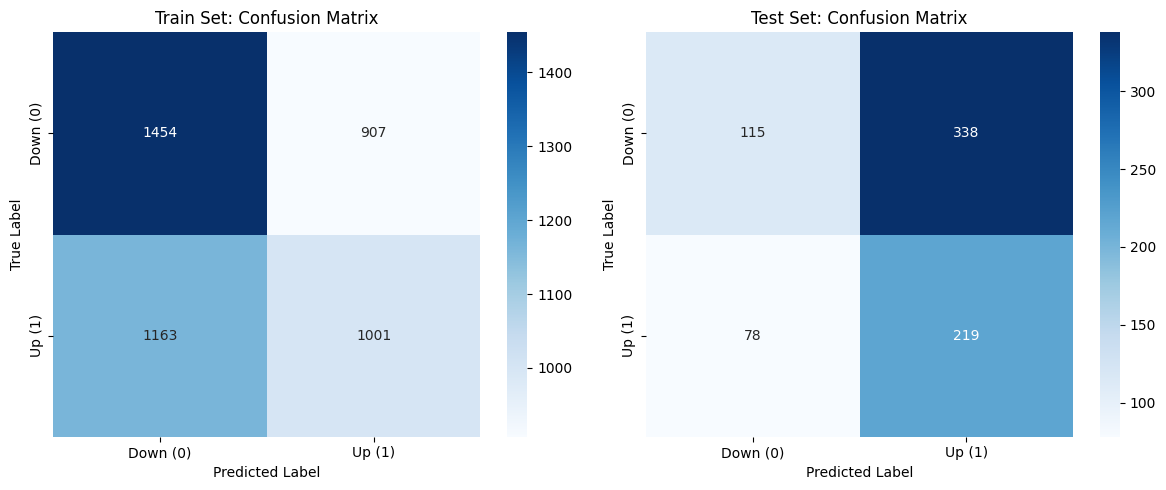

In [22]:
train_cm = confusion_matrix(train_actual_direction, train_pred_direction)
test_cm = confusion_matrix(test_actual_direction, test_pred_direction)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Down (0)", "Up (1)"], yticklabels=["Down (0)", "Up (1)"], ax=axes[0])
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")
axes[0].set_title("Train Set: Confusion Matrix")

sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Down (0)", "Up (1)"], yticklabels=["Down (0)", "Up (1)"], ax=axes[1])
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")
axes[1].set_title("Test Set: Confusion Matrix")

plt.tight_layout()
plt.show()

In [23]:
train_report = classification_report(train_actual_direction, train_pred_direction, target_names=["Down (0)", "Up (1)"])
test_report = classification_report(test_actual_direction, test_pred_direction, target_names=["Down (0)", "Up (1)"])

print("Train Classification Report:\n", train_report)
print("\nTest Classification Report:\n", test_report)

Train Classification Report:
               precision    recall  f1-score   support

    Down (0)       0.56      0.62      0.58      2361
      Up (1)       0.52      0.46      0.49      2164

    accuracy                           0.54      4525
   macro avg       0.54      0.54      0.54      4525
weighted avg       0.54      0.54      0.54      4525


Test Classification Report:
               precision    recall  f1-score   support

    Down (0)       0.60      0.25      0.36       453
      Up (1)       0.39      0.74      0.51       297

    accuracy                           0.45       750
   macro avg       0.49      0.50      0.43       750
weighted avg       0.52      0.45      0.42       750



### Calculate Stock Price Predictions

In [24]:
train_pred_percent = train_pred_magnitude * (2 * train_pred_direction - 1)
test_pred_percent = test_pred_magnitude * (2 * test_pred_direction - 1)

In [25]:
train_data['predicted_percent_close'] = np.nan
for ticker in np.unique(train_tickers):
    stock_indices = np.where(train_tickers == ticker)[0]
    train_data.loc[train_data['stock_name'] == ticker, 'predicted_percent_close'] = train_pred_percent[stock_indices]

In [26]:
test_data['predicted_percent_close'] = np.nan
for ticker in np.unique(test_tickers):
    stock_indices = np.where(test_tickers == ticker)[0]
    test_data.loc[test_data['stock_name'] == ticker, 'predicted_percent_close'] = test_pred_percent[stock_indices]

In [27]:
train_data['predicted_close'] = np.nan

for ticker in np.unique(train_tickers):
    scaler = scalers[ticker]
    
    stock_rows = train_data['stock_name'] == ticker
    stock_predicted_percent = train_data.loc[stock_rows, 'predicted_percent_close'].values.reshape(-1, 1)

    if len(stock_predicted_percent) > 0:
        # Create dummy feature set for inverse transformation
        dummy_features = np.zeros((len(stock_predicted_percent), len(feature_cols)))  
        
        # Denormalize and compute predicted close price
        denormalized_predicted_percent = scaler.inverse_transform(
            np.column_stack([dummy_features, stock_predicted_percent])
        )[:, -1]

        # Shift the actual close price by one day (previous close)
        prev_close_price = train_data.loc[stock_rows, 'close'].shift(1)

        # Compute predicted close price
        train_data.loc[stock_rows, 'predicted_close'] = prev_close_price * (1 + denormalized_predicted_percent / 100)

In [28]:
test_data['predicted_close'] = np.nan

for ticker in np.unique(test_tickers):
    scaler = scalers[ticker]
    
    stock_rows = test_data['stock_name'] == ticker
    stock_predicted_percent = test_data.loc[stock_rows, 'predicted_percent_close'].values.reshape(-1, 1)

    if len(stock_predicted_percent) > 0:
        # Create dummy feature set for inverse transformation
        dummy_features = np.zeros((len(stock_predicted_percent), len(feature_cols)))  
        
        # Denormalize and compute predicted close price
        denormalized_predicted_percent = scaler.inverse_transform(
            np.column_stack([dummy_features, stock_predicted_percent])
        )[:, -1]

        # Shift the actual close price by one day (previous close)
        prev_close_price = test_data.loc[stock_rows, 'close'].shift(1)

        # Compute predicted close price
        test_data.loc[stock_rows, 'predicted_close'] = prev_close_price * (1 + denormalized_predicted_percent / 100)

In [29]:
train_data['forecast'] = np.nan

for ticker in np.unique(train_tickers):
    stock_rows = train_data['stock_name'] == ticker
    stock_df = train_data.loc[stock_rows].copy()

    # Get the first actual close price (the starting reference point)
    first_actual_close = stock_df['close'].iloc[0]

    # Initialize an array to store accumulated predictions
    accumulated_prices = [first_actual_close]

    # Compute accumulated forecast
    for i in range(1, len(stock_df)):
        predicted_change = stock_df['predicted_close'].iloc[i] - stock_df['close'].iloc[i-1]
        new_forecast_price = accumulated_prices[-1] + predicted_change
        accumulated_prices.append(new_forecast_price)

    # Store results back in the DataFrame
    train_data.loc[stock_rows, 'forecast'] = accumulated_prices

In [30]:
test_data['forecast'] = np.nan

for ticker in np.unique(test_tickers):
    stock_rows = test_data['stock_name'] == ticker
    stock_df = test_data.loc[stock_rows].copy()

    # Get the first actual close price (the starting reference point)
    first_actual_close = stock_df['close'].iloc[0]

    # Initialize an array to store accumulated predictions
    accumulated_prices = [first_actual_close]

    # Compute accumulated forecast
    for i in range(1, len(stock_df)):
        predicted_change = stock_df['predicted_close'].iloc[i] - stock_df['close'].iloc[i-1]
        new_forecast_price = accumulated_prices[-1] + predicted_change
        accumulated_prices.append(new_forecast_price)

    # Store results back in the DataFrame
    test_data.loc[stock_rows, 'forecast'] = accumulated_prices

### Plot Predictions

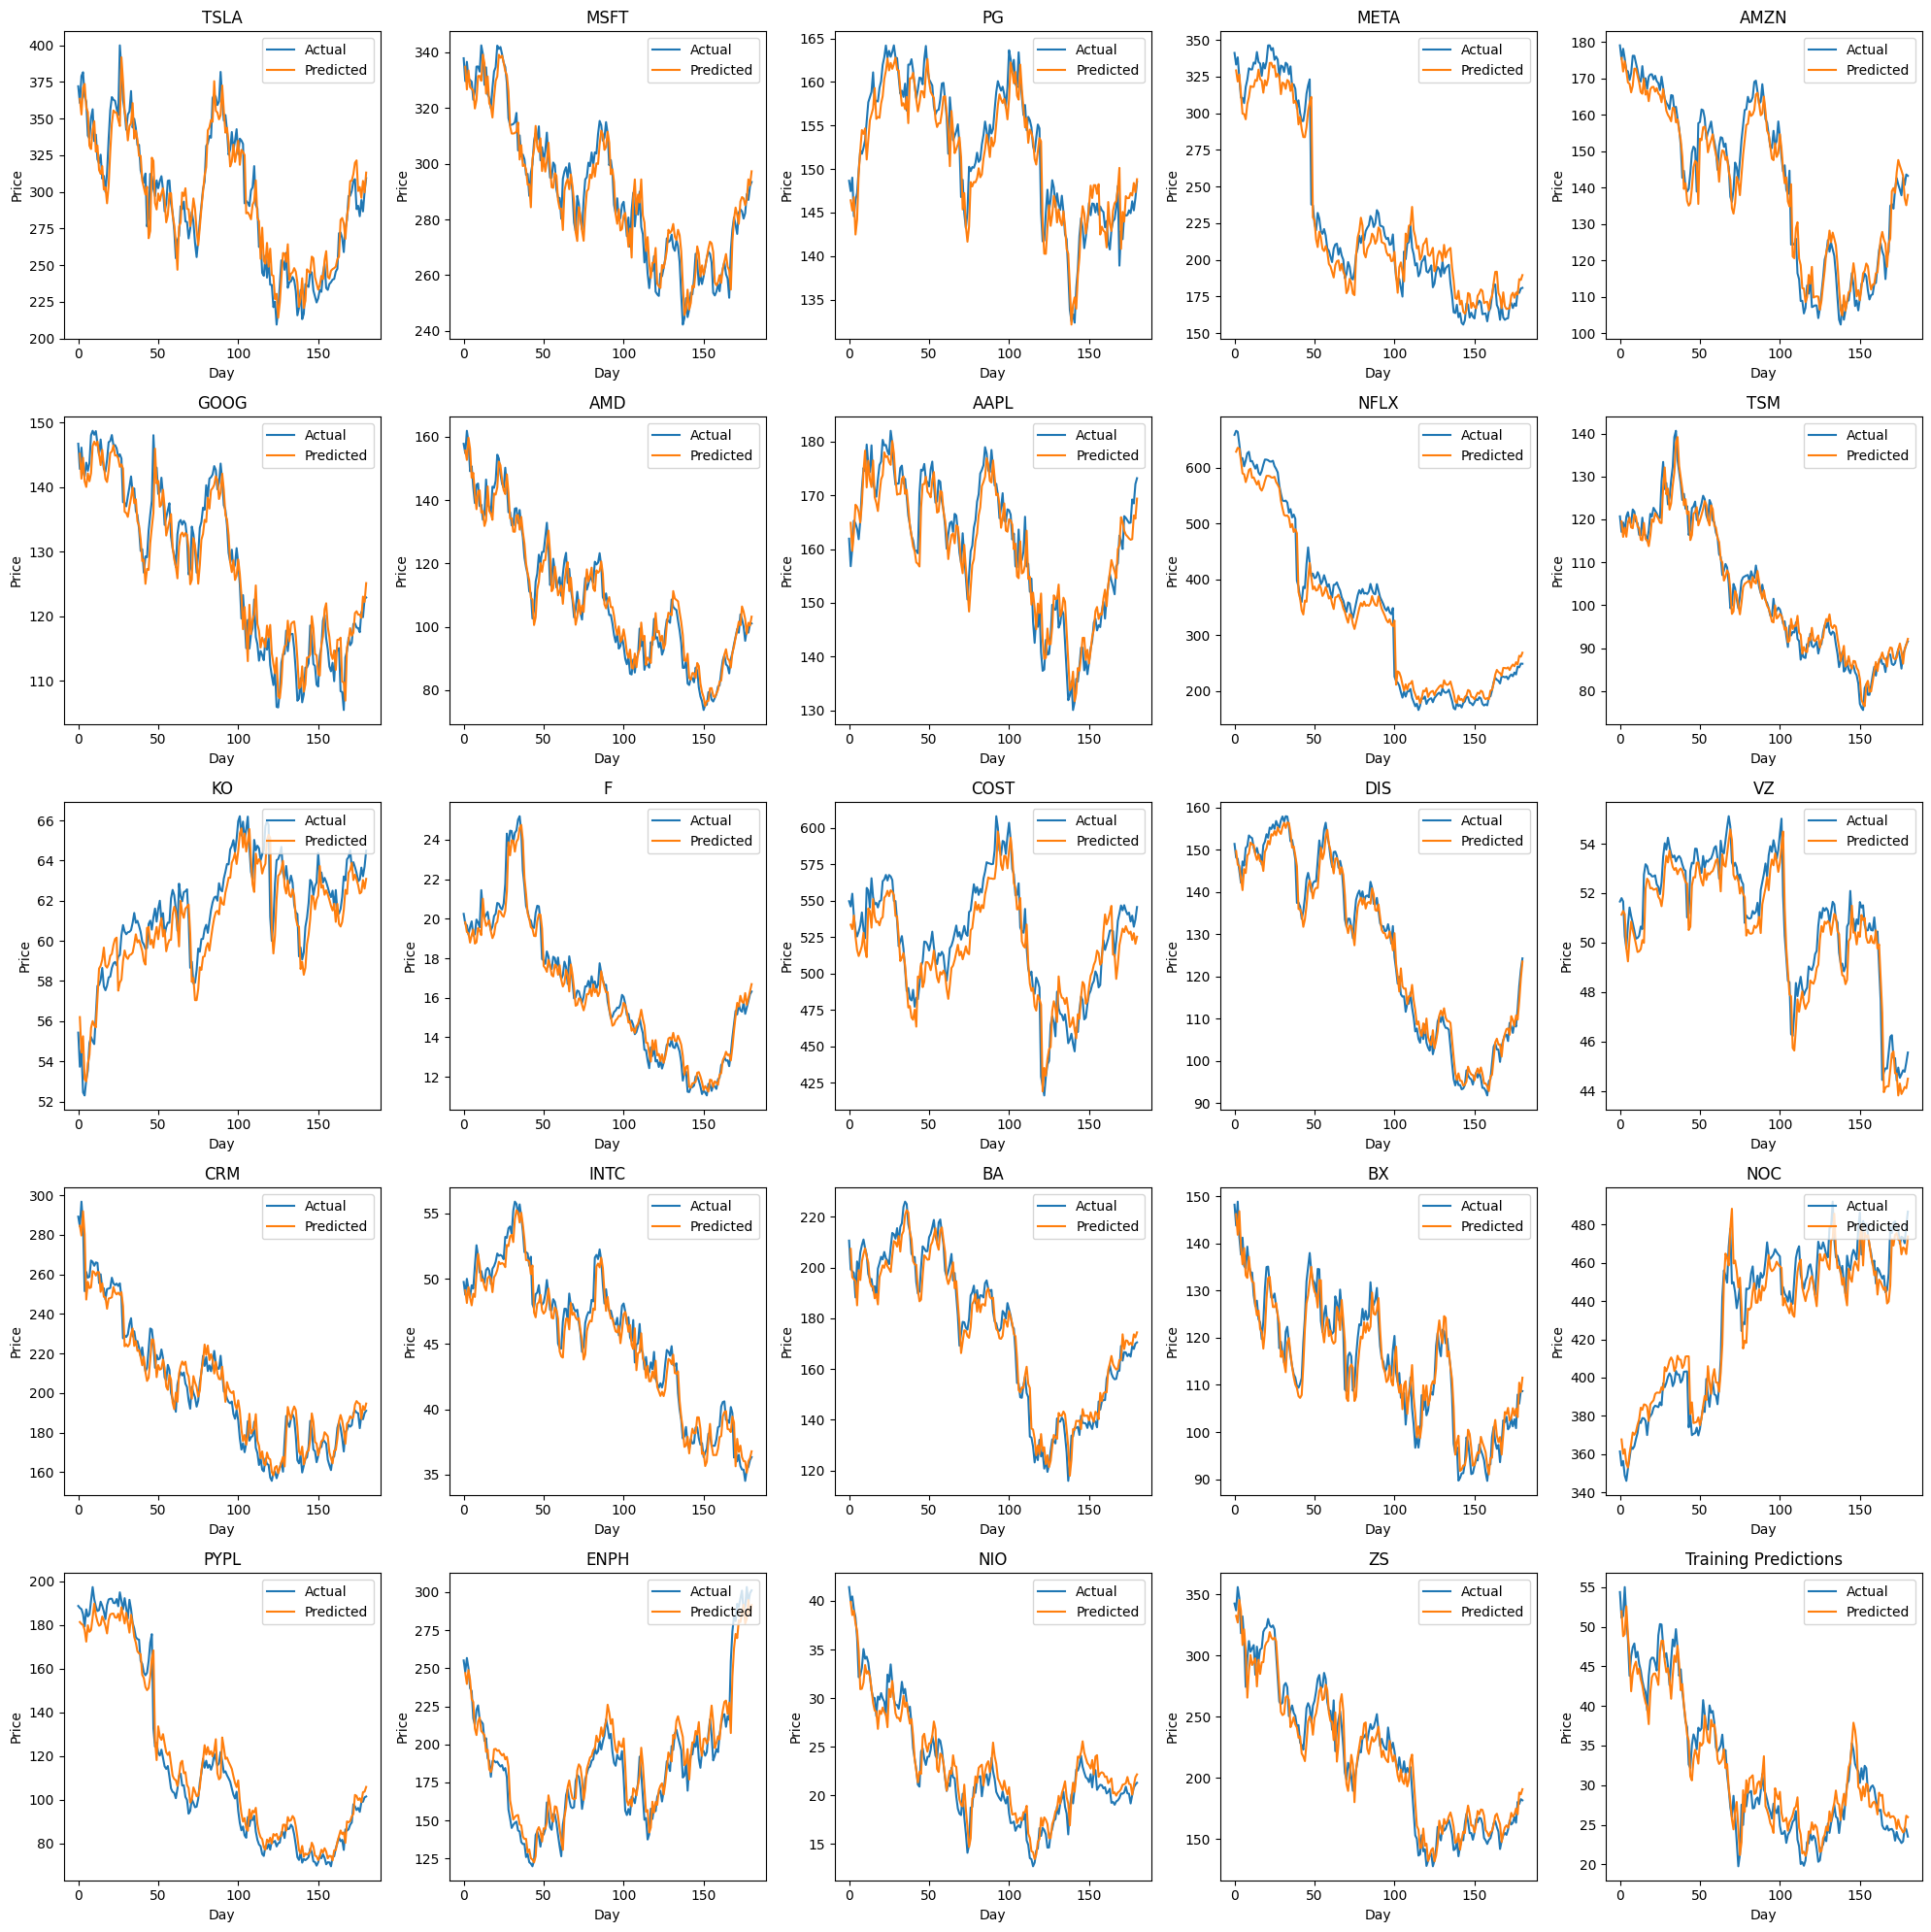

In [31]:
grid_size = (5, 5)
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(20, 20))
axes = axes.flatten()

for i, stock in enumerate(tickers):

    stock_df = train_data[train_data['stock_name'] == stock]
    stock_df.reset_index(inplace=True)

    ax = axes[i]
    ax.plot(stock_df.index, stock_df['close'], label='Actual')
    ax.plot(stock_df.index, stock_df['predicted_close'], label='Predicted')
    ax.set_title(f'{stock}')
    ax.set_xlabel('Day')
    ax.set_ylabel('Price')
    ax.legend(loc='upper right')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.title('Training Predictions')
plt.tight_layout()
plt.show()

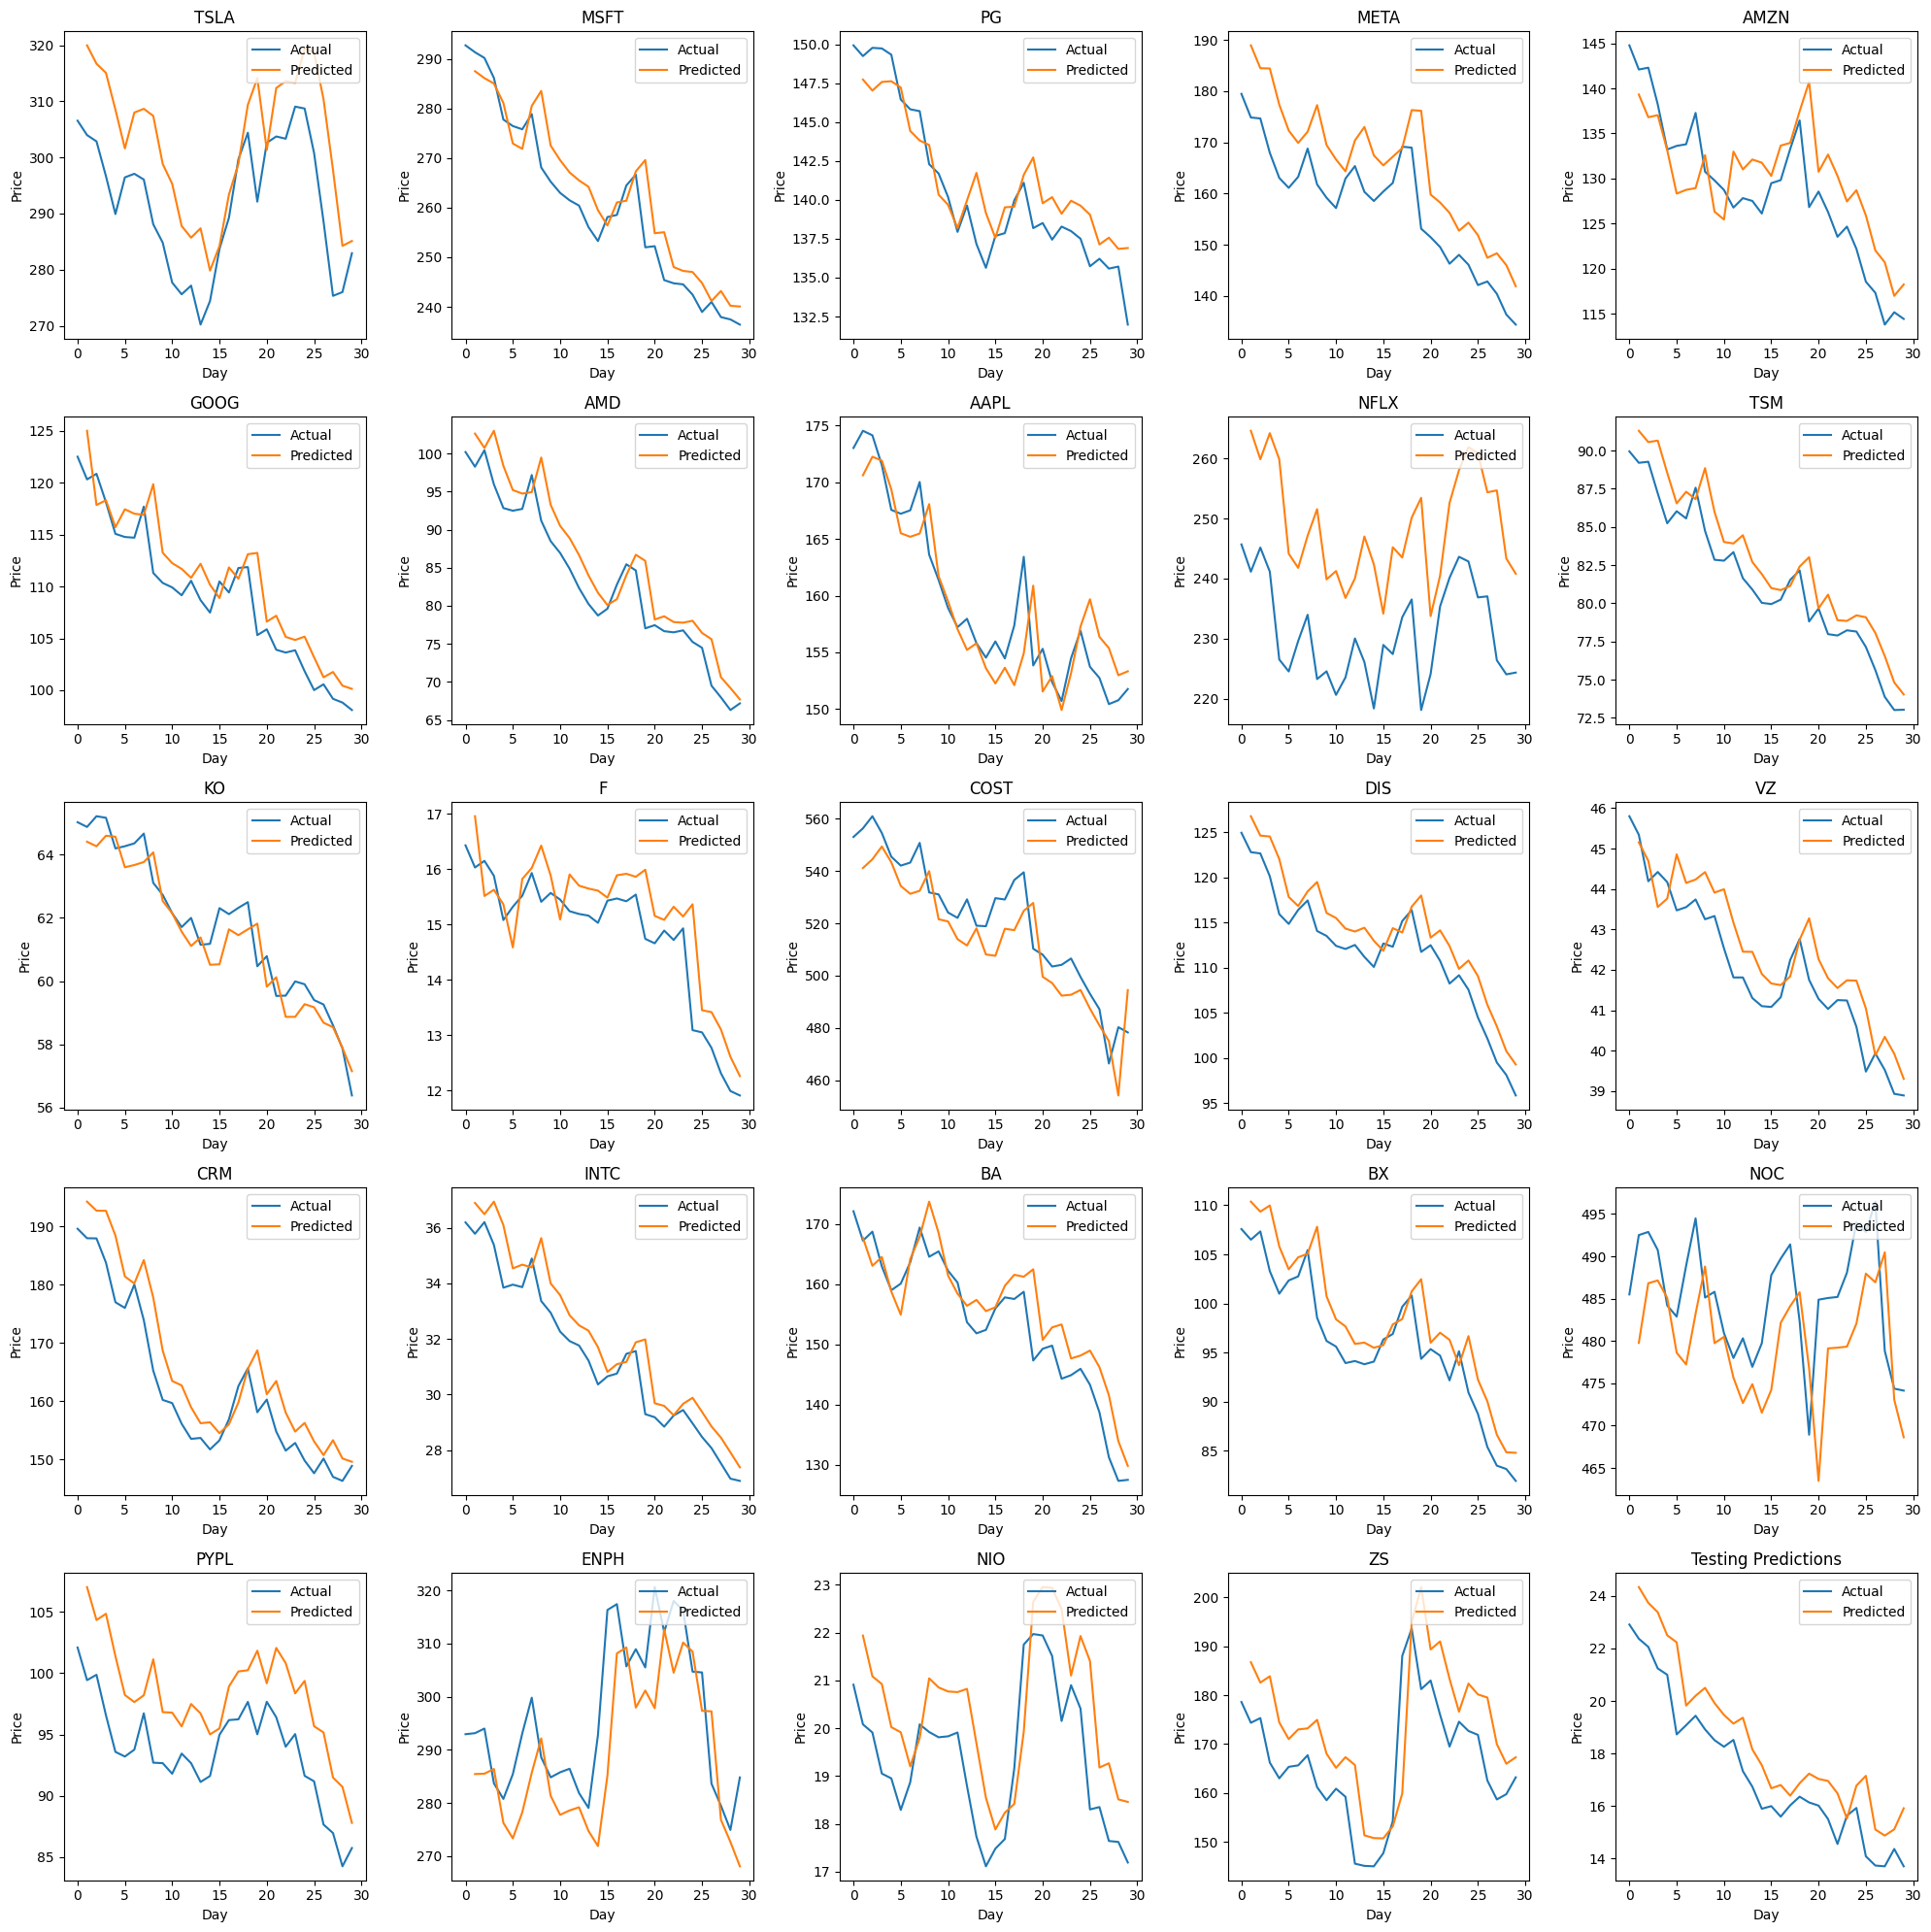

In [32]:
grid_size = (5, 5)
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(20, 20))
axes = axes.flatten()

for i, stock in enumerate(tickers):

    stock_df = test_data[test_data['stock_name'] == stock]
    stock_df.reset_index(inplace=True)

    ax = axes[i]
    ax.plot(stock_df.index, stock_df['close'], label='Actual')
    ax.plot(stock_df.index, stock_df['predicted_close'], label='Predicted')
    ax.set_title(f'{stock}')
    ax.set_xlabel('Day')
    ax.set_ylabel('Price')
    ax.legend(loc='upper right')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.title('Testing Predictions')
plt.tight_layout()
plt.show()

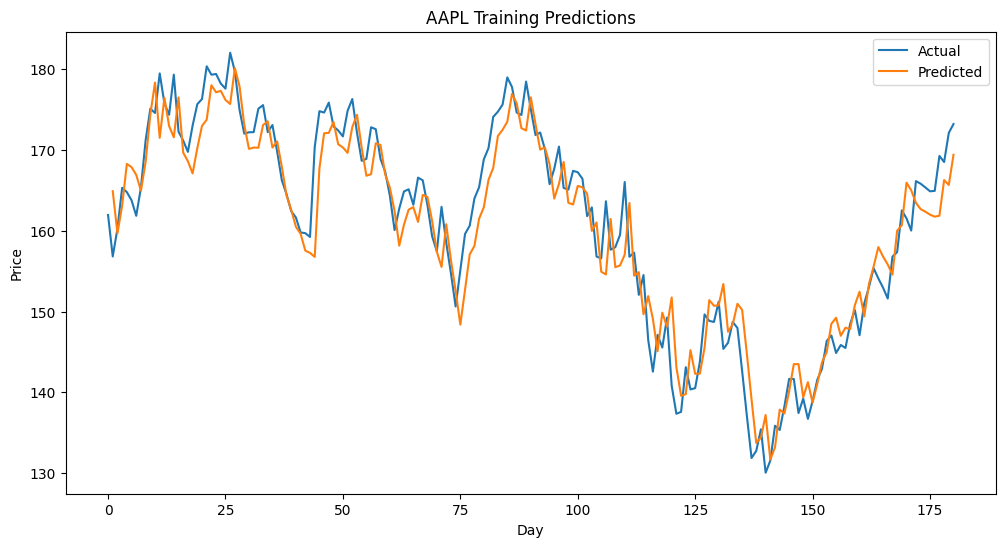

In [41]:
stock = "AAPL"

stock_df = train_data[train_data['stock_name'] == stock]
stock_df.reset_index(inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(stock_df.index, stock_df['close'], label='Actual')
plt.plot(stock_df.index, stock_df['predicted_close'], label='Predicted')
plt.xlabel('Day')
plt.ylabel('Price')
plt.title(f'{stock} Training Predictions')
plt.legend(loc='upper right')

plt.show()

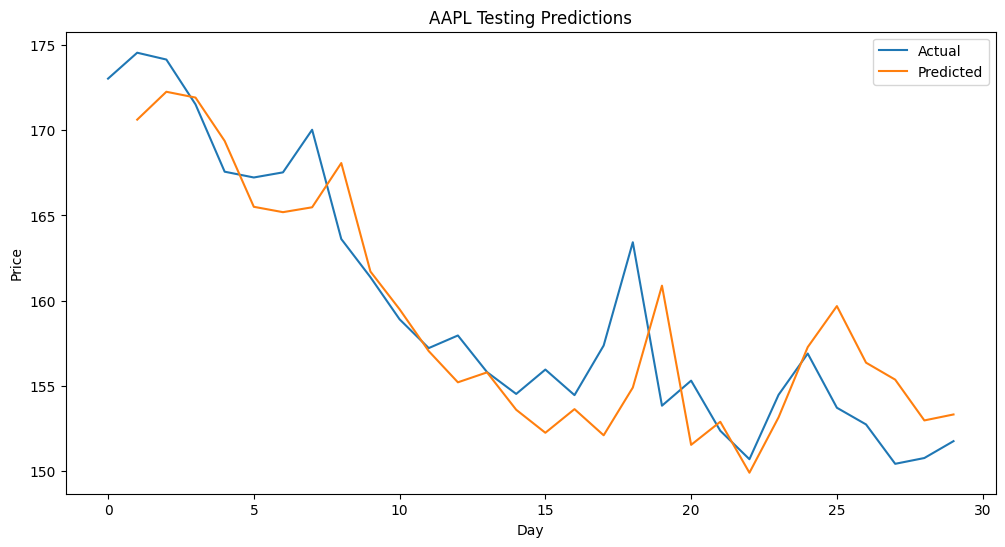

In [42]:
stock = "AAPL"

stock_df = test_data[test_data['stock_name'] == stock]
stock_df.reset_index(inplace=True)

plt.figure(i, figsize=(12, 6))
plt.plot(stock_df.index, stock_df['close'], label='Actual')
plt.plot(stock_df.index, stock_df['predicted_close'], label='Predicted')
plt.xlabel('Day')
plt.ylabel('Price')
plt.title(f'{stock} Testing Predictions')
plt.legend(loc='upper right')

plt.show()

### Plot Forecast

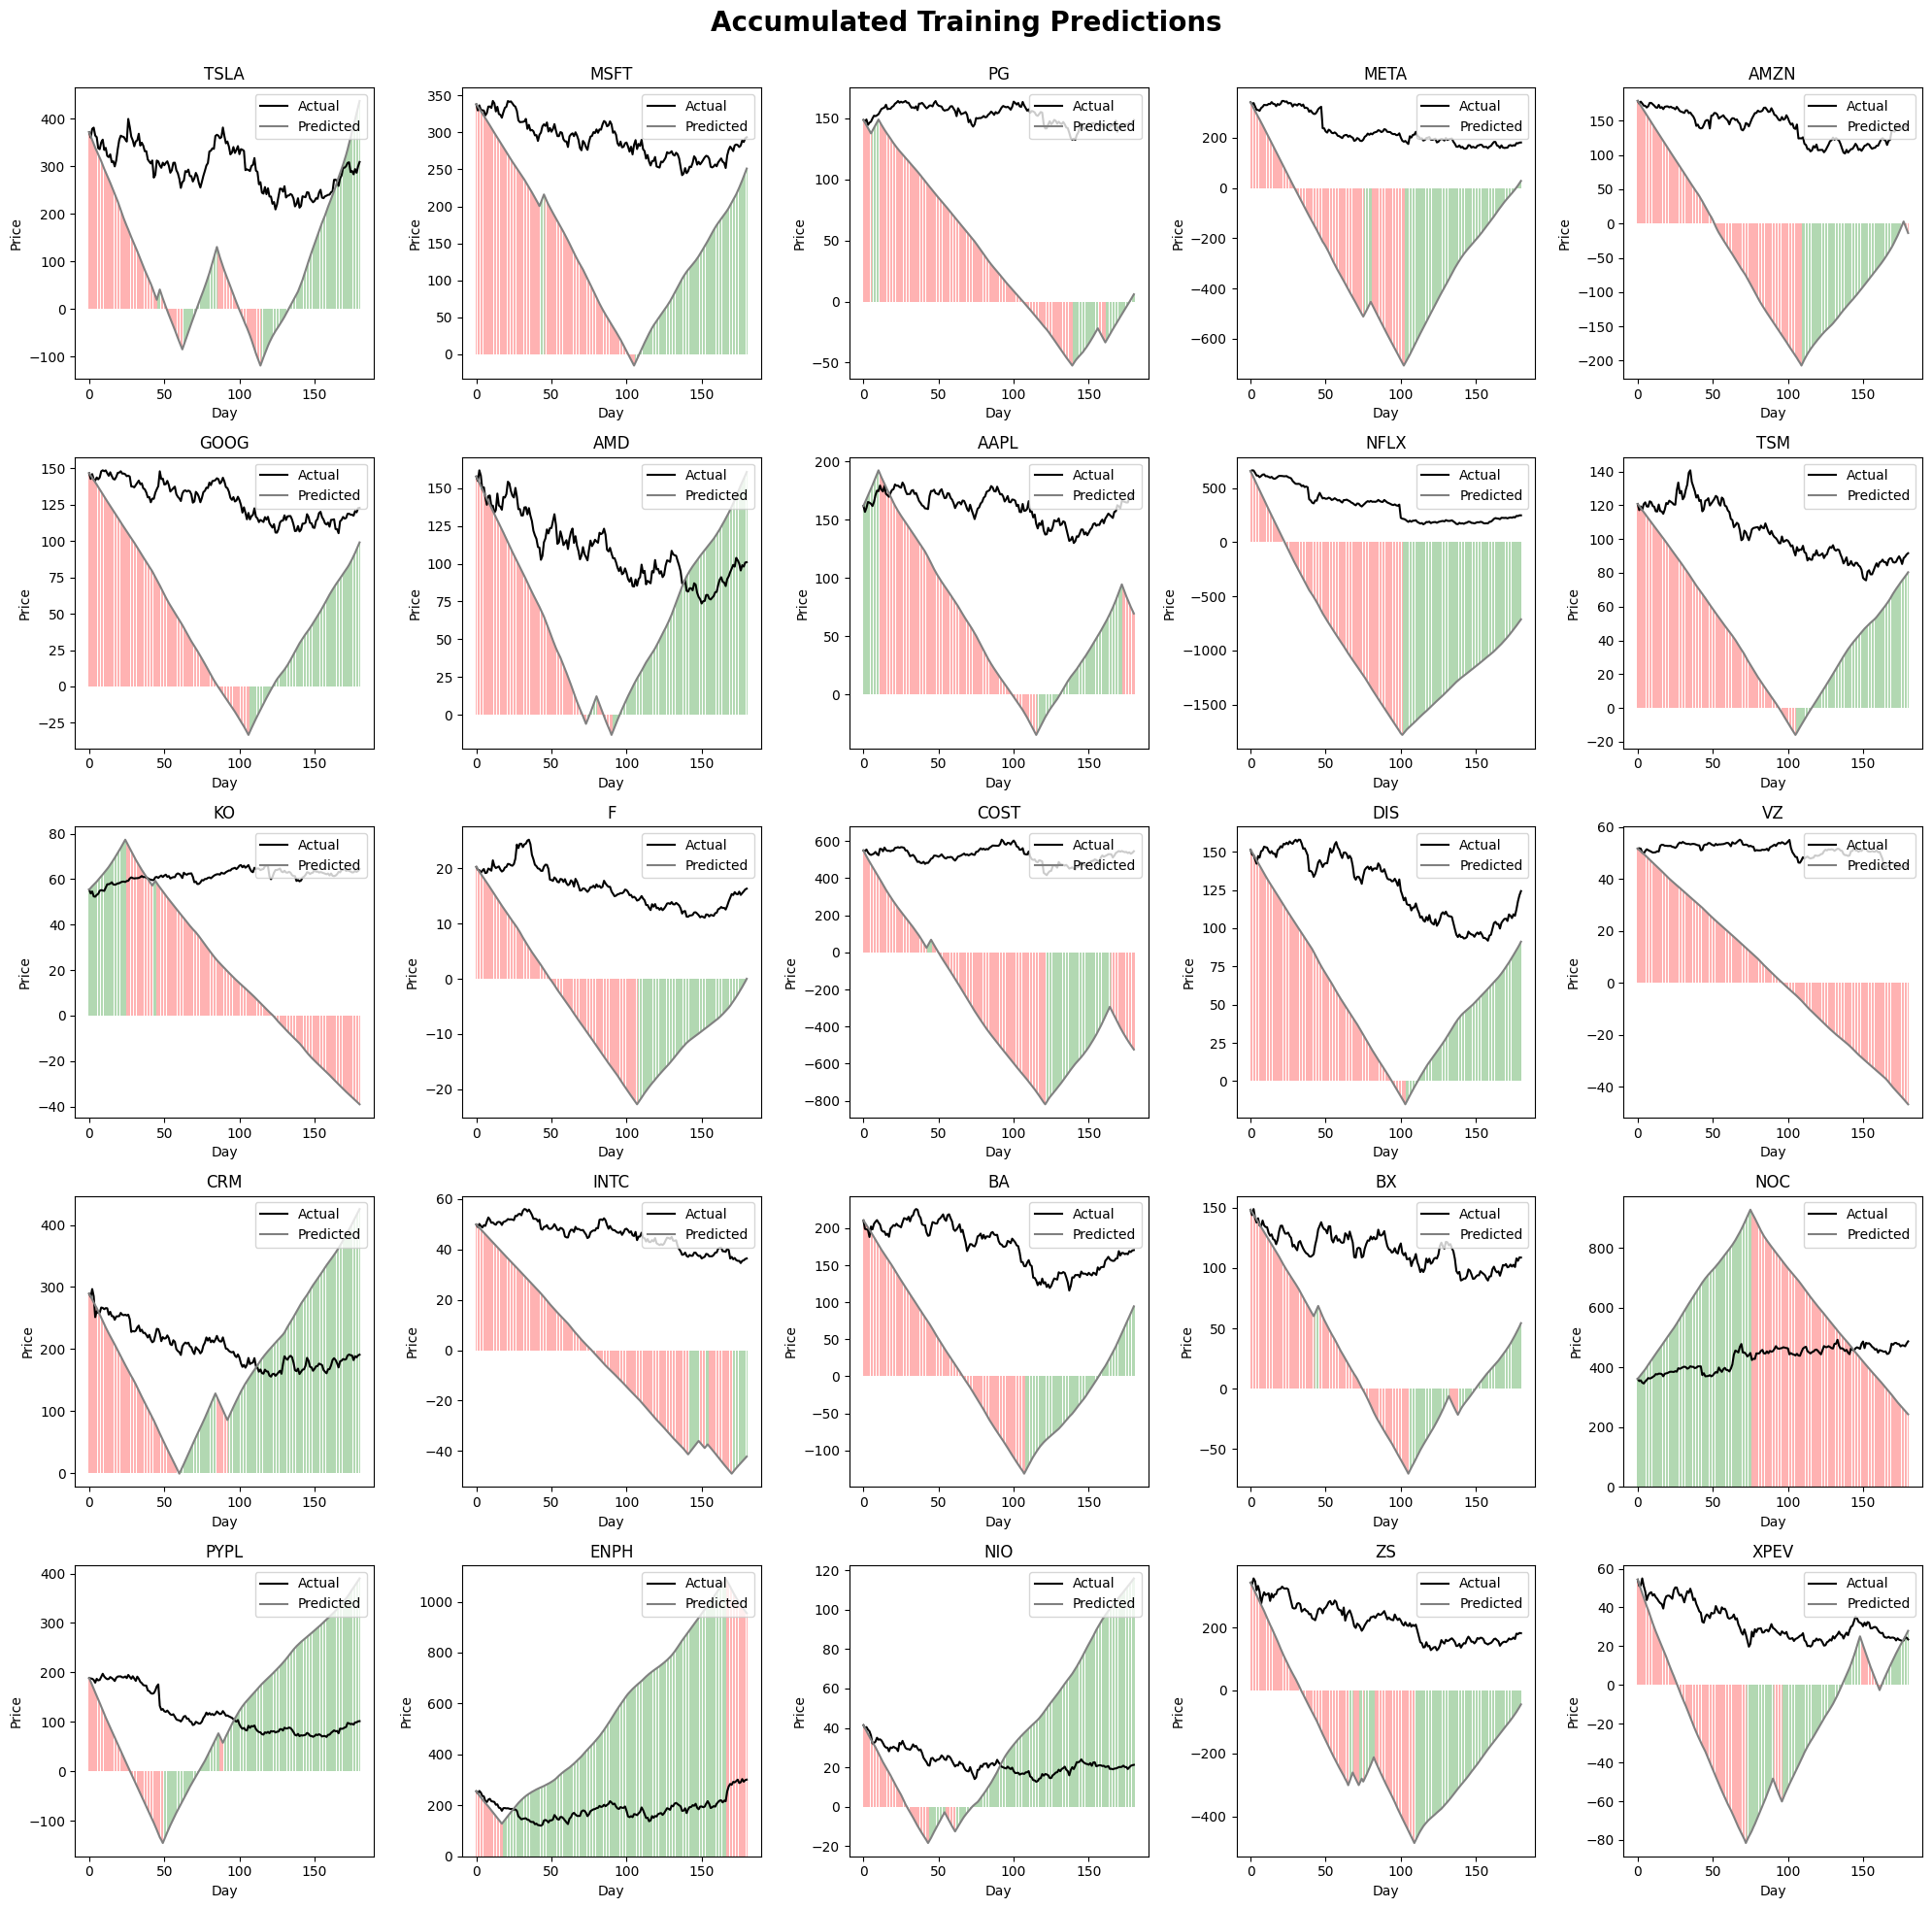

In [40]:
grid_size = (5, 5)
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(20, 20))
axes = axes.flatten()

fig.suptitle('Accumulated Training Predictions', fontsize=20, fontweight='bold')

for i, stock in enumerate(tickers):

    stock_df = train_data[train_data['stock_name'] == stock].copy()
    stock_df.reset_index(inplace=True)
  
    ax = axes[i]
    
    colors = ['green' if v > 0 else 'red' for v in stock_df['predicted_percent_close']]
    
    ax.bar(stock_df.index, stock_df['forecast'], color=colors, alpha=0.3)
    ax.plot(stock_df.index, stock_df['close'], label='Actual', color='black')
    ax.plot(stock_df.index, stock_df['forecast'], label='Predicted', color='grey')
    ax.set_title(f'{stock}')
    ax.set_xlabel('Day')
    ax.set_ylabel('Price')
    ax.legend(loc='upper right')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

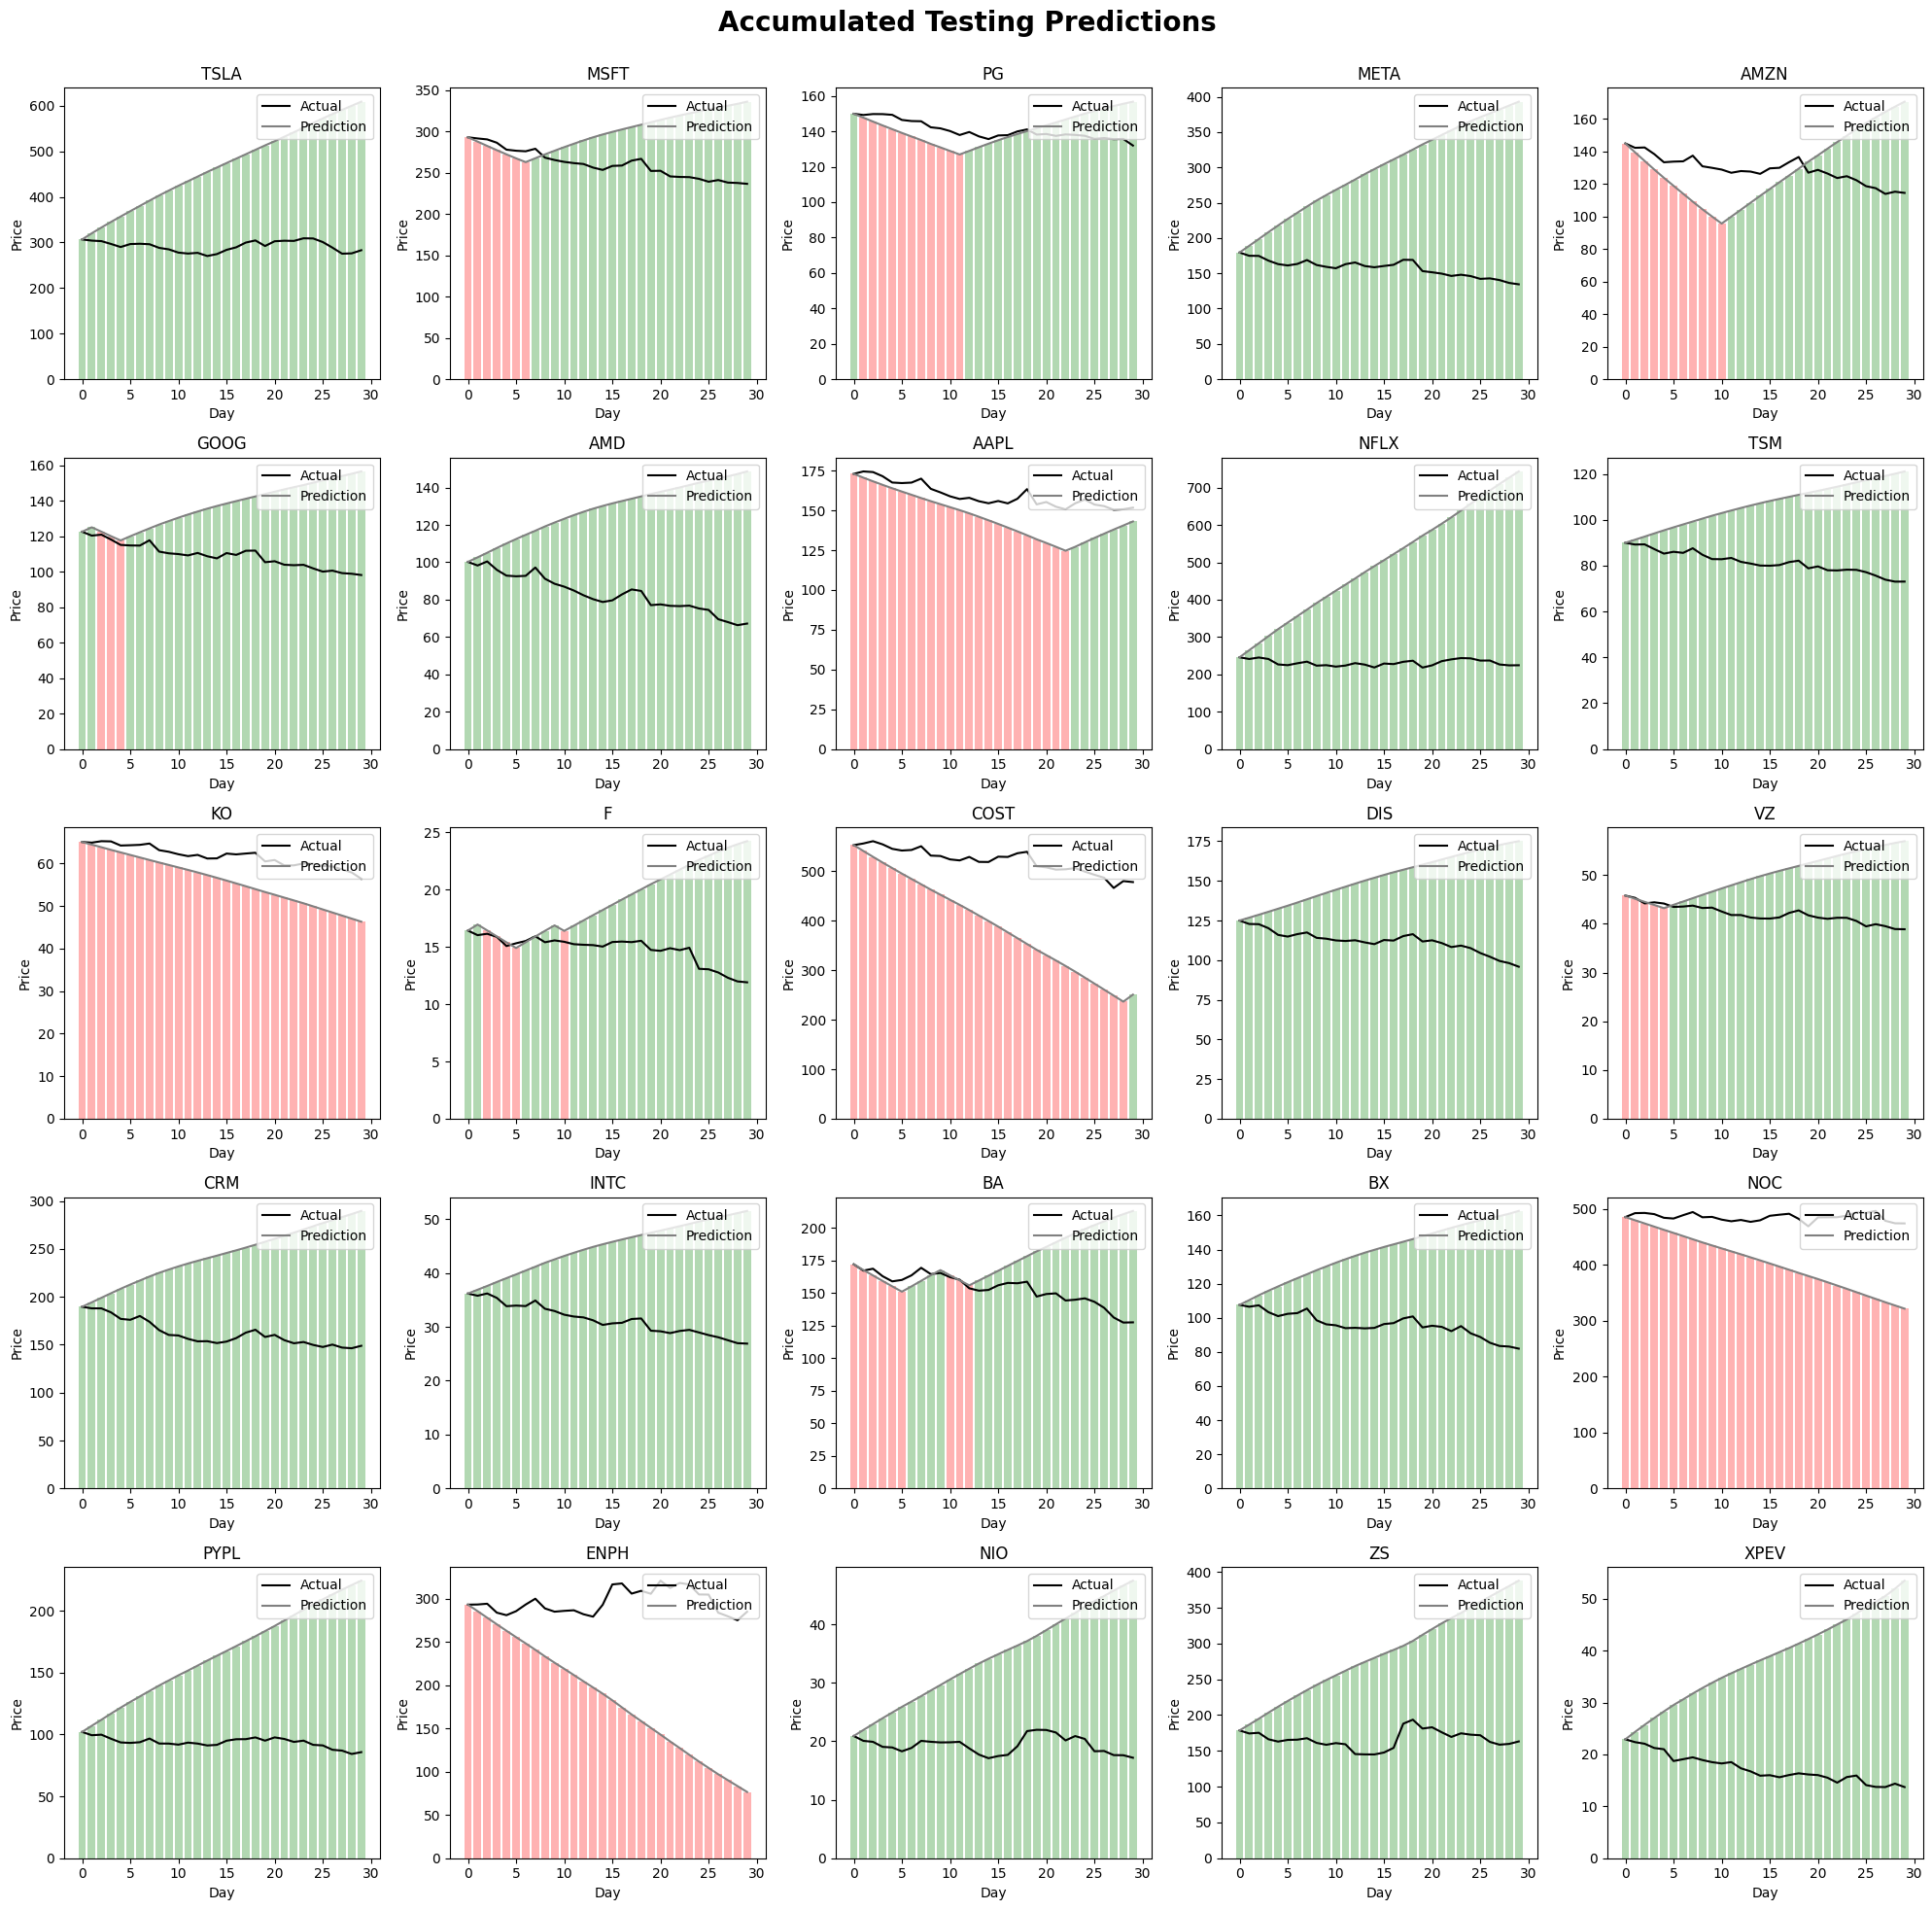

In [39]:
grid_size = (5, 5)
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(20, 20))
axes = axes.flatten()

fig.suptitle('Accumulated Testing Predictions', fontsize=20, fontweight='bold')

for i, stock in enumerate(tickers):

    stock_df = test_data[test_data['stock_name'] == stock].copy()
    stock_df.reset_index(inplace=True)
  
    ax = axes[i]
    
    colors = ['green' if v > 0 else 'red' for v in stock_df['predicted_percent_close']]

    ax.bar(stock_df.index, stock_df['forecast'], color=colors, alpha=0.3)
    ax.plot(stock_df.index, stock_df['close'], label='Actual', color='black')
    ax.plot(stock_df.index, stock_df['forecast'], label='Prediction', color='grey')
    ax.set_title(f'{stock}')
    ax.set_xlabel('Day')
    ax.set_ylabel('Price')
    ax.legend(loc='upper right')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

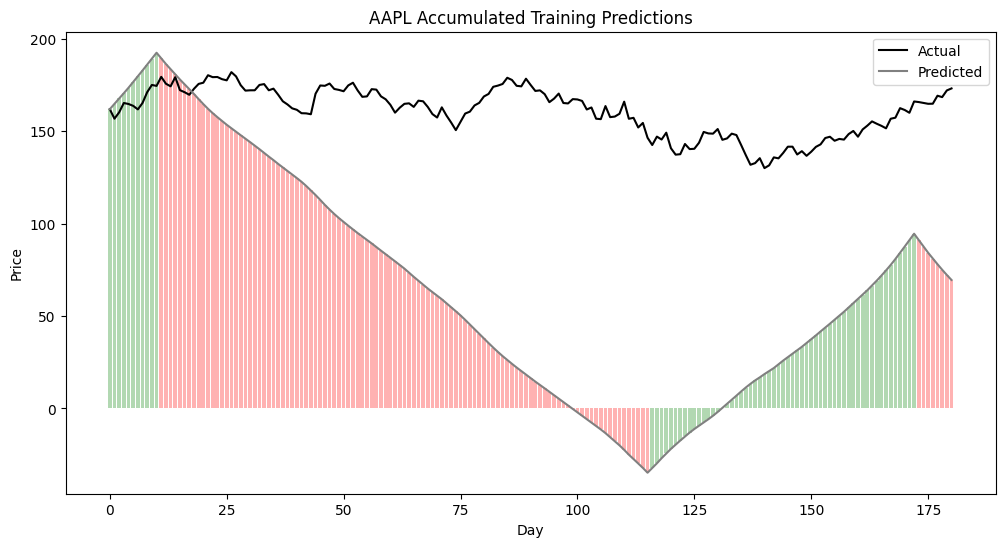

In [37]:
stock = "AAPL"

stock_df = train_data[train_data['stock_name'] == stock]
stock_df.reset_index(inplace=True)

plt.figure(figsize=(12, 6))
plt.bar(stock_df.index, stock_df['forecast'], 
        color=['green' if v > 0 else 'red' for v in stock_df['predicted_percent_close']], 
        alpha=0.3)
plt.plot(stock_df.index, stock_df['close'], label='Actual', color='black')
plt.plot(stock_df.index, stock_df['forecast'], label='Predicted', color='grey')
plt.xlabel('Day')
plt.ylabel('Price')
plt.title(f'{stock} Accumulated Training Predictions')
plt.legend(loc='upper right')
plt.show()

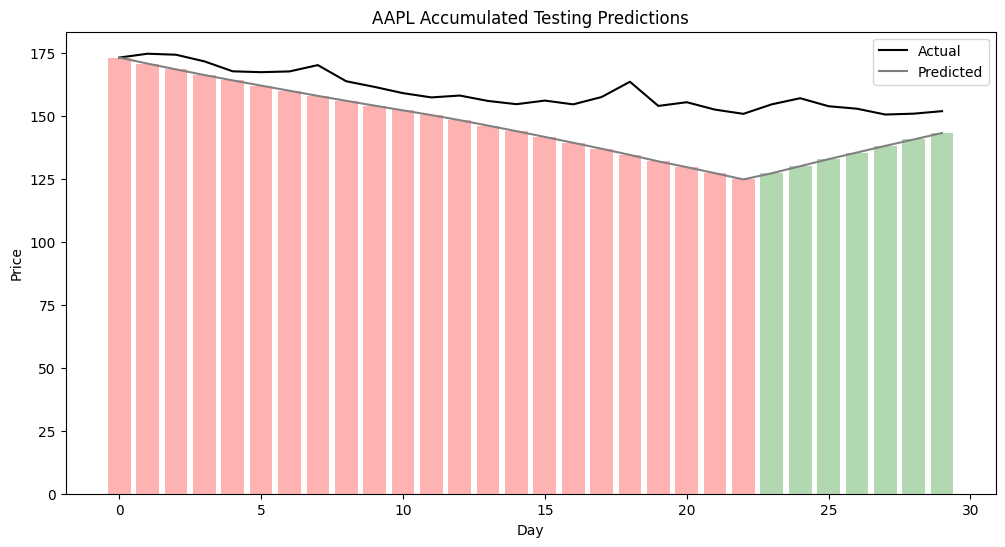

In [38]:
stock = "AAPL"

stock_df = test_data[test_data['stock_name'] == stock]
stock_df.reset_index(inplace=True)

plt.figure(figsize=(12, 6))
plt.bar(stock_df.index, stock_df['forecast'], 
        color=['green' if v > 0 else 'red' for v in stock_df['predicted_percent_close']], 
        alpha=0.3)
plt.plot(stock_df.index, stock_df['close'], label='Actual', color='black')
plt.plot(stock_df.index, stock_df['forecast'], label='Predicted', color='grey')
plt.xlabel('Day')
plt.ylabel('Price')
plt.title(f'{stock} Accumulated Testing Predictions')
plt.legend(loc='upper right')
plt.show()